In [5]:
#pip install cvxopt
#pip install librosa

In [69]:
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import cvxopt
import seaborn as sns
import itertools
import os
import warnings

import librosa
from IPython.display import Audio

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier      # KNN
from sklearn.svm import SVC                             # SVM
from sklearn.tree import DecisionTreeClassifier         # Árbol de Decisión
from sklearn.linear_model import LogisticRegression     # Regresión Logística
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn.exceptions import ConvergenceWarning

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


## Cargando el DataSet al entorno de trabajo

Download the dataset from [here](https://drive.google.com/drive/folders/1VfthX0TIhDMsc7rp3ES6ApVwdBLSK4_e?usp=sharing) or simply create a shortcut in your Google Drive.

----

- The following code demonstrates how to load your Google Drive.
- Rewrite the path in case your dataset is located in a different directory on your google drive.

In [60]:
path = '/Users/elvisrojasmonguia/Documents/Python courses/UTEC/hackaton 6/DataSet_Cat_Dog/'

In [10]:
y, sr = librosa.load(path + "/test/dog/dog_barking_15.wav" )
mfccs = librosa.feature.mfcc(y=y, sr=sr)
feacture_vector = np.array(mfccs.mean(axis = 1))
print("Feacture Vector of the dog sound :" , feacture_vector)
Audio(data=y, rate=sr)

# Uncomment to listen to an example of the sound of a cat
y, sr = librosa.load(path + "/test/cat/cat_88.wav" )
Audio(data=y, rate=sr)


Feacture Vector of the dog sound : [-292.7673     118.35525    -60.666008   -29.93634    -27.66046
  -29.684113   -21.906305   -20.586025    -6.1135497  -11.085019
   -2.099951     7.559067     0.7164106    4.3795233   -2.8995044
  -13.28882     -7.2556744   -1.2405516   -4.5105443   -4.4990487]


The code provided below accepts the path to your database directory and the type of dataset you wish to load as input. The default dataset is 'train', but you can also opt for 'test'. It returns the feature vectors for all the audio files, along with their labels (1, 0, -1) if you're employing SVM. Should you prefer, the labels can be adjusted to 1 or 0 for use with logistic regression.

In [12]:
def encode(path, data_type='train'):
    data = []
    directory_cat = os.listdir(os.path.join(path, data_type, "cat"))
    directory_dog = os.listdir(os.path.join(path, data_type, "dog"))

    # Procesar archivos de gatos
    for f in directory_cat:
        y, sr = librosa.load(os.path.join(path, data_type, "cat", f))
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        data.append([fv, 1, f, 'cat'])  #  1 para gatos

    # Procesar archivos de perros
    for f in directory_dog:
        y, sr = librosa.load(os.path.join(path, data_type, "dog", f))
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        data.append([fv, 0, f, 'dog'])  # 0 para perros

    # Crear DataFrame
    df = pd.DataFrame(data, columns=['features', 'label', 'filename', 'category'])

    # Añadir índice original
    df['original_index'] = np.arange(len(df))

    # Mezclar DataFrame
    df = df.sample(frac=1).reset_index(drop=True)

    # Separar características y etiquetas
    x = np.vstack(df['features'].values)
    y = df['label'].values
    filenames = df['filename'].values
    categories = df['category'].values
    original_indices = df['original_index'].values

    return x, y, original_indices, filenames, categories


## Data Train and Data Test

By this point, your team should already have the training and testing data fully prepared for use in your model. Therefore, your team should focus solely on running your models and achieving good results.

In [14]:

x_train, y_train, original_indices_train, filenames_train, categories_train = encode(path, 'train')
x_test, y_test, original_indices_test, filenames_test, categories_test      = encode(path, 'test')


In [71]:
# Supongamos que ya has cargado tus datos en x_train y x_test
x_train_shape = x_train.shape
x_test_shape = x_test.shape

print(f"Dimensiones de x_train: {x_train_shape}")
print(f"Dimensiones de x_test: {x_test_shape}")


Dimensiones de x_train: (210, 20)
Dimensiones de x_test: (67, 20)


# Model Evaluation - Hyperparameters search

Apply the following classification models: KNN, SVM, Decision Trees, and Logistic Regression. Evaluate their performance using the metrics Accuracy, Precision, Recall, and F1 Score. Compare the results and present the model with the best performance.


----

### Módelos de clasificación


| **Modelo**                  | **Descripción**                                                 | **Enlace a la documentación y ejemplos**                       |
|-----------------------------|-----------------------------------------------------------------|---------------------------------------------------------------|
| **K-Nearest Neighbors (KNN)** | Clasificador basado en la proximidad de los puntos más cercanos. | [KNN - scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) |
| **Support Vector Machine (SVM)** | Encuentra el hiperplano óptimo para separar clases.           | [SVM - scikit-learn](https://scikit-learn.org/stable/modules/svm.html) |
| **Árbol de Decisión**       | Clasificador que utiliza un árbol jerárquico basado en reglas.   | [Decision Tree - scikit-learn](https://scikit-learn.org/stable/modules/tree.html#classification) |
| **Regresión Logística**     | Clasificador lineal basado en probabilidades.                   | [Logistic Regression - scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) |

-----





### Métricas


| **Métrica**          | **Descripción**                                                                 | **Enlace a la documentación y ejemplos**                        |
|-----------------------|-------------------------------------------------------------------------------|----------------------------------------------------------------|
| **Accuracy**          | Proporción de predicciones correctas respecto al total de muestras.            | [Accuracy - scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| **Precision**         | Proporción de predicciones positivas correctas respecto a todas las predicciones positivas. | [Precision - scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| **Recall (Sensibilidad)** | Proporción de positivos reales identificados correctamente.                    | [Recall - scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| **F1-Score**          | Media armónica entre la Precision y el Recall, útil para datos desbalanceados. | [F1-Score - scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |


----


In [19]:

# Configuración global 
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
N_JOBS = 2  # Evita sobrecarga de memoria

# Hiperparámetros  
param_grids = {
    'Logistic Regression': {
        'C': uniform(0.001, 999.999),
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2'],
        'max_iter': [10000]
    },
    'KNN': {
        'n_neighbors': randint(3, 50),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
    },
    'SVC': {
        'C': uniform(0.01, 100),
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20, 30, 50],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300, 400, 500],
        'max_depth': [None, 5, 10, 20, 30, 50],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200, 300, 400, 500],
        'learning_rate': uniform(0.01, 0.5),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.1, 0.9),  
        'colsample_bytree': uniform(0.1, 0.9),  
        'min_child_weight': randint(1, 10),
        'eval_metric': ['logloss', 'error', 'auc']
    }
}


# Entrenamiento unificado
best_models = {}
best_params = {}

num_iter = 100
num_iter_heavymodels = 30

for name in param_grids:
    print(f"\nOptimizando {name}...")
    
    model = {
        'Logistic Regression': LogisticRegression(),
        'KNN': KNeighborsClassifier(),
        'SVC': SVC(probability=True),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier()
    }[name]

    search = RandomizedSearchCV(
        model,
        param_grids[name],
        n_iter=num_iter_heavymodels if name in ['XGBoost', 'SVC'] else num_iter,
        scoring='f1_weighted',
        cv=3,
        n_jobs=N_JOBS,
        verbose=0
    )
    
    search.fit(x_train, y_train)
    best_models[name] = search.best_estimator_
    best_params[name] = search.best_params_
    
    print(f"Mejores parámetros {name}:")
    print(search.best_params_)
    print(f"F1-Score: {search.best_score_:.3f}")



Optimizando Logistic Regression...
Mejores parámetros Logistic Regression:
{'C': 8.432452791702515, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
F1-Score: 0.865

Optimizando KNN...
Mejores parámetros KNN:
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
F1-Score: 0.889

Optimizando SVC...
Mejores parámetros SVC:
{'C': 44.64234901139834, 'gamma': 'scale', 'kernel': 'rbf'}
F1-Score: 0.898

Optimizando Decision Tree...
Mejores parámetros Decision Tree:
{'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 14}
F1-Score: 0.861

Optimizando Random Forest...
Mejores parámetros Random Forest:
{'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 13, 'n_estimators': 200}
F1-Score: 0.884

Optimizando XGBoost...
Mejores parámetros XGBoost:
{'colsample_bytree': 0.5239766794506533, 'eval_metric': 'error', 'learning_rate': 0.04848344613042987, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7345287033537885}
F1-Score: 0.885


In [20]:
# Evaluación final
results = []
for name, model in best_models.items():
    y_pred = model.predict(x_test)
    results.append({
        'Modelo': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred, average='weighted')
    })

results_df  = pd.DataFrame(results).sort_values('F1', ascending=False)
results_df.round(3)

,Modelo,Accuracy,F1
0,Logistic Regression,0.896,0.895
2,SVC,0.881,0.881
5,XGBoost,0.851,0.849
1,KNN,0.836,0.835
4,Random Forest,0.836,0.833
3,Decision Tree,0.791,0.792


## Mejores parametros para cada modelo

In [22]:
# Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(**best_params['Logistic Regression']),
    'KNN': KNeighborsClassifier(**best_params['KNN']),
    'SVC': SVC(**best_params['SVC']),
    'Decision Tree': DecisionTreeClassifier(**best_params['Decision Tree']),
    'Random Forest': RandomForestClassifier(**best_params['Random Forest']),
    'XGBoost': XGBClassifier(**best_params['XGBoost'], use_label_encoder=False)
}

# Entrenar y evaluar cada modelo
results = []
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({'Model': name, 'Accuracy': accuracy, 'F1 Score': f1})



In [23]:
def matriz_confusion(y_pred,Tipo):
 matrix = confusion_matrix(y_test, y_pred)
 f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=["Dog", 'Cat'], columns=["Dog", 'Cat'])
 sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
 plt.title("Confusion Matrix"  + Tipo ), plt.tight_layout()
 plt.xlabel("Predicted")
 plt.ylabel("Real")
 plt.show()

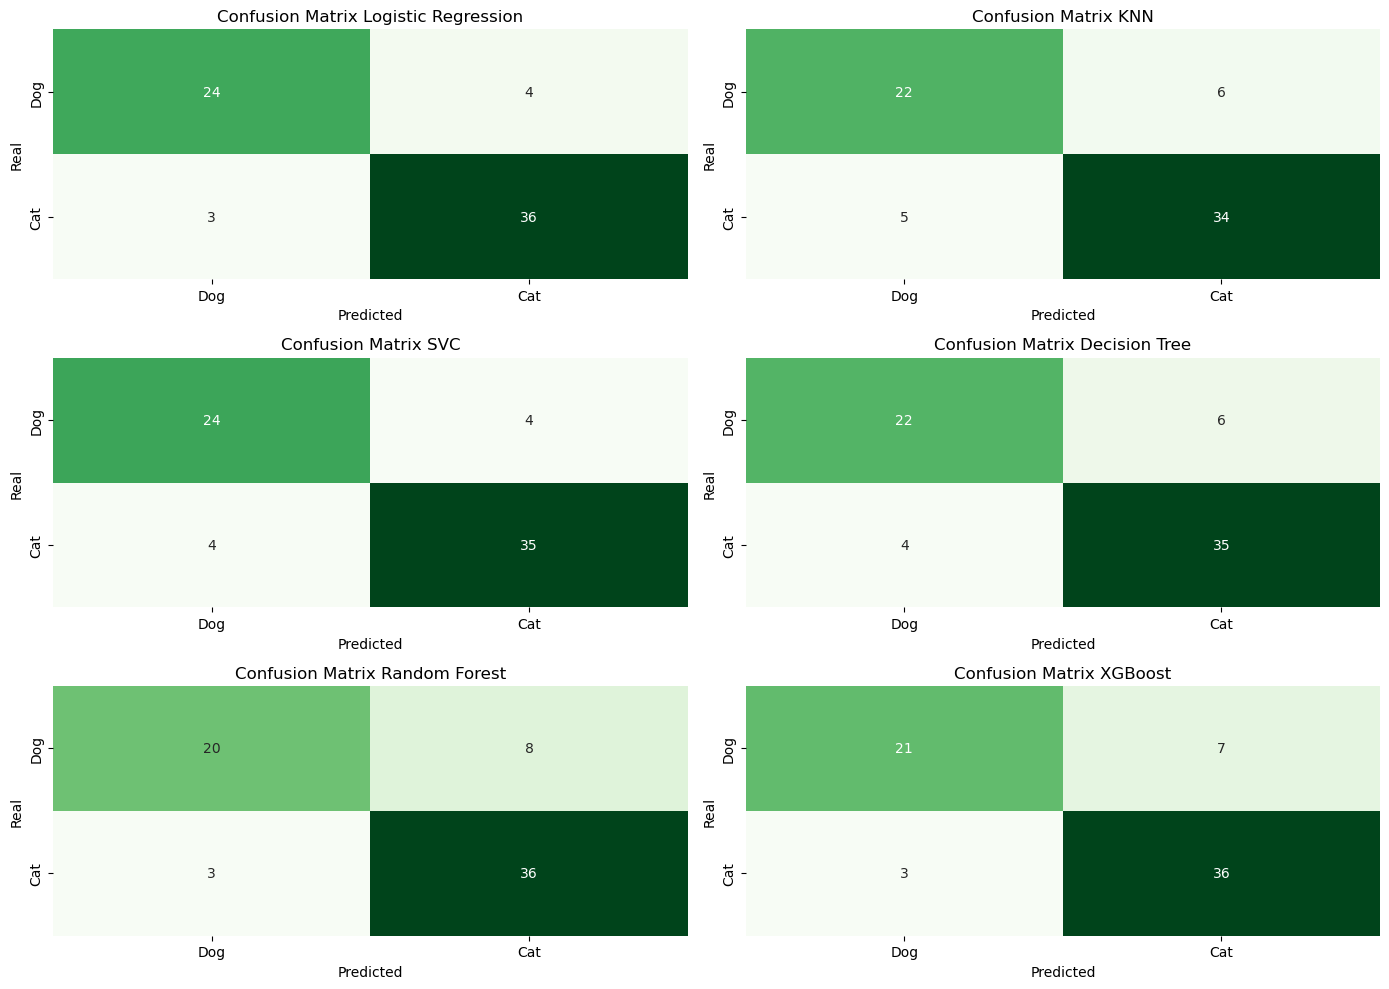

In [24]:
# Diccionario para almacenar las predicciones
predictions = {}

# Entrenar los modelos y generar predicciones
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred_test = model.predict(x_test)
    predictions[name] = y_pred_test

# Definir la función para crear la matriz de confusión
def matriz_confusion(ax, y_test, y_pred, title, percentage_matrix):
    matrix = confusion_matrix(y_test, y_pred)

    if percentage_matrix:
      f2 = pd.DataFrame(matrix.astype('float')  / matrix.sum(axis=1)[:, np.newaxis] , index=["Dog", 'Cat'], columns=["Dog", 'Cat'])
    else:
      f2 = pd.DataFrame(matrix.astype('float'), index=["Dog", 'Cat'], columns=["Dog", 'Cat'])


    sns.heatmap(f2, annot=True, cbar=None, cmap="Greens", ax=ax)
    ax.set_title(f"Confusion Matrix {title}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")

# Crear la figura de 2x2 para las matrices de confusión
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# Generar las matrices de confusión para cada modelo en los subplots correspondientes
for idx, (name, y_pred_test) in enumerate(predictions.items()):
    row, col = divmod(idx, 2)
    matriz_confusion(axs[row, col],y_test , y_pred_test, name, False )

plt.tight_layout()
plt.show()


## Identificar a las observaciones que son mal predichas

En este caso, el objetivo es identificar a los falsos positivos y falsos negativos.


In [27]:
# Convertir x_test y y_test a DataFrame y Series de pandas si no lo están
if isinstance(x_test, np.ndarray):
    x_test = pd.DataFrame(x_test)
if isinstance(y_test, np.ndarray):
    y_test = pd.Series(y_test)

# Crear y entrenar el modelo de regresión logística
logistic_regression = LogisticRegression(**best_params['Logistic Regression'])
logistic_regression.fit(x_train, y_train)

# Generar predicciones para el conjunto de prueba
y_pred_test = logistic_regression.predict(x_test)

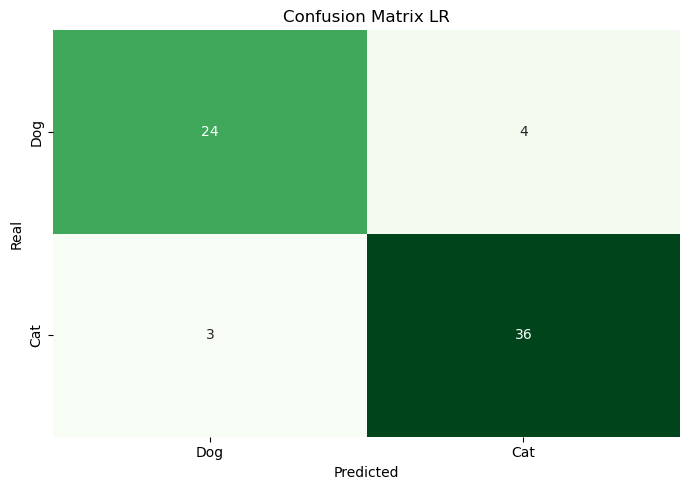

In [28]:
# Crear la figura de 1x1 para la matriz de confusión
fig, ax = plt.subplots(figsize=(7, 5))  # ax en lugar de axs

# Generar la matriz de confusión para el modelo seleccionado
matriz_confusion(ax, y_test, y_pred_test, "LR", False)  # Usar ax

plt.tight_layout()
plt.show()

In [29]:
# Identificar falsos positivos y falsos negativos
fp_indices = np.where((y_test == 1) & (y_pred_test == 0))[0]  # Falsos positivos: Gato (1) predicho como Perro (0)
fn_indices = np.where((y_test == 0) & (y_pred_test == 1))[0]  # Falsos negativos: Perro predicho como Gato

print("Logistic Regression - Falsos Positivos (FP):")
print(fp_indices)
print("Logistic Regression - Falsos Negativos (FN):")
print(fn_indices)


Logistic Regression - Falsos Positivos (FP):
[27 35 38]
Logistic Regression - Falsos Negativos (FN):
[ 3 15 29 33]


In [30]:
# Verificar archivos para falsos positivos: Gatos (reales) predichos como Perros
print("Audios correspondientes a Falsos Positivos (FP):")
for idx in fp_indices:
    if categories_test[idx] == 'cat':
        fp_audio_file = os.path.join(path, 'test', 'cat', filenames_test[idx])
    else:
        print(f"Error: {filenames_test[idx]} no es un archivo de gato.")
        continue
    print(fp_audio_file)
    y, sr = librosa.load(fp_audio_file)
    display(Audio(data=y, rate=sr))


Audios correspondientes a Falsos Positivos (FP):
/Users/elvisrojasmonguia/Documents/Python courses/UTEC/hackaton 6/DataSet_Cat_Dog/test/cat/cat_67.wav


/Users/elvisrojasmonguia/Documents/Python courses/UTEC/hackaton 6/DataSet_Cat_Dog/test/cat/cat_86.wav


/Users/elvisrojasmonguia/Documents/Python courses/UTEC/hackaton 6/DataSet_Cat_Dog/test/cat/cat_85.wav


In [31]:
# Verificar archivos para falsos negativos: Perros (reales) predichos como Gatos
print("Audios correspondientes a Falsos Negativos (FN):")
for idx in fn_indices:
    if categories_test[idx] == 'dog':
        fn_audio_file = os.path.join(path, 'test', 'dog', filenames_test[idx])
    else:
        print(f"Error: {filenames_test[idx]} no es un archivo de perro.")
        continue
    print(fn_audio_file)
    y, sr = librosa.load(fn_audio_file)
    display(Audio(data=y, rate=sr))


Audios correspondientes a Falsos Negativos (FN):
/Users/elvisrojasmonguia/Documents/Python courses/UTEC/hackaton 6/DataSet_Cat_Dog/test/dog/dog_barking_8.wav


/Users/elvisrojasmonguia/Documents/Python courses/UTEC/hackaton 6/DataSet_Cat_Dog/test/dog/dog_barking_3.wav


/Users/elvisrojasmonguia/Documents/Python courses/UTEC/hackaton 6/DataSet_Cat_Dog/test/dog/dog_barking_24.wav


/Users/elvisrojasmonguia/Documents/Python courses/UTEC/hackaton 6/DataSet_Cat_Dog/test/dog/dog_barking_7.wav
